In [1]:
# imports

## allow interaction with the plots
%matplotlib widget

%load_ext autoreload
%autoreload 2

# add the main directory reference and import 'imports.py'
import sys
import os

if ".." not in sys.path:
    sys.path.insert(0, "..")
from imports import *

logger = logging.getLogger()
logger.setLevel(level=logging.WARN)

__builtins__.verbosity = 4
# Set the HF_HOME environment variable
os.environ["HF_HOME"] = "/run/media/HUNK/DATASETS/HF"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [2]:
# Declare a few global data/train params
from lib.optim import WarmupCosineLR
from typing import override
from lib.train import *


class params:
    num_workers = 24
    batch_size = 160
    seq_len = 140
    files_per_epoch = 800

    max_epochs = 200
    lr = 0.005

    flush_epoch_units = False
    loss_every = 800


# customize trainer
class SeqTrainer(Trainer):
    @override
    def prepare_batch(self, batch):
        if self.gpus:
            # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
            # batch = batch[0].pin_memory().to(self.device, non_blocking=True)
            batch = batch[0].to(self.device)
        else:
            batch = batch[0].to(self.device)
        return batch[:, :-1], batch[:, 1:]

    # from nanogpt
    # @override
    # def prepare_optimizer(self, weight_decay, learning_rate, betas, device_type):
    #     # start with all of the candidate parameters
    #     param_dict = {pn: p for pn, p in self.model.named_parameters()}
    #     # filter out those that do not require grad
    #     param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
    #     # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    #     # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    #     decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    #     nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    #     optim_groups = [
    #         {"params": decay_params, "weight_decay": weight_decay},
    #         {"params": nodecay_params, "weight_decay": 0.0},
    #     ]
    #     num_decay_params = sum(p.numel() for p in decay_params)
    #     num_nodecay_params = sum(p.numel() for p in nodecay_params)
    #     print(
    #         f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
    #     )
    #     print(
    #         f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters"
    #     )
    #     # Create AdamW optimizer and use the fused version if it is available
    #     fused_available = "fused" in inspect.signature(torch.optim.AdamW).parameters
    #     use_fused = fused_available and device_type == "cuda"
    #     extra_args = dict(fused=True) if use_fused else dict()
    #     self.optim = torch.optim.AdamW(
    #         optim_groups, lr=learning_rate, betas=betas, **extra_args
    #     )

    #     self.sched = WarmupCosineLR(
    #         self.optim,
    #         warmup_iters=200,
    #         min_lr=6e-6,
    #         lr_decay_iters=10000,
    #         lr=params.lr,
    #     )


def scheduler(optimizer, ts_opts):
    return WarmupCosineLR(
        optimizer,
        warmup_iters=200,
        min_lr=6e-6,
        lr_decay_iters=10000,
        lr=params.lr,
    )


In [3]:
from data.chessPgn import *


dt = PGNData(PGNDataConfig.create(params))

# dt.preview()


number of parameters: 91.04M
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(7797, 768)
    (wpe): Embedding(140, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=7797, bias=False)
)


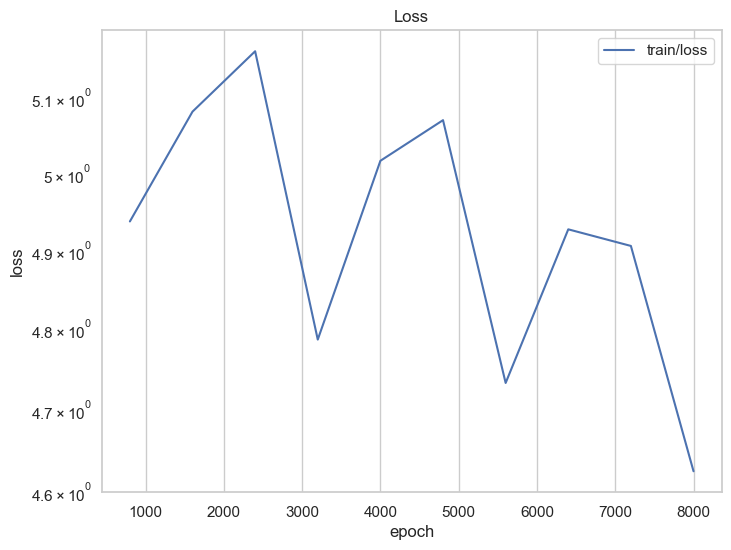

Epochs progress:   0%|          | 0/100 [00:00<?, ?Epoch/s]

/ARCHIVE/Personal/2186474940/.pixi/envs/dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  self.pid = os.fork()
illegal san: 'Ke4' in 8/4R3/1p6/4p2k/1r4p1/4K1P1/5P2/8 w - - 2 45 while parsing <Game at 0x7a04c7d7c4d0 ('Jumabayev Rinat (KAZ)' vs. 'Caruana Fabiano (USA)', '2021.07.18' at 'Sochi')>
illegal san: 'Kd5' in 8/P4R2/3k1pp1/4p2p/2K5/3P3P/5PP1/r7 b - - 5 48 while pars

In [ ]:
from models.nanoGPT import *

model = GPT(
    GPTConfig(
        vocab_size=dt.classes,
        bias=True,
        seq_len=params.seq_len,
    )
)
# model = RWKV(RWKVConfig(vocab_size=dt.classes, bias=True, seq_len=params.seq_len))

print(model)
trainer = SeqTrainer(
    TrainerConfig.create(
        params,
        epoch_end_callback=dt.shuffle_files,
        save_model_every=5,
        load_previous=False,
        scheduler=scheduler,
    )
)

trainer.fit(model, dt.loaders())


In [ ]:
trainer._save_model()

In [ ]:
from models.nanoRWKV import *

import gc

del model, trainer
gc.collect()
torch.cuda.empty_cache()

model = GPT(
    GPTConfig(
        vocab_size=dt.classes,
        bias=True,
        seq_len=params.seq_len,
    )
)
# model = RWKV(RWKVConfig(vocab_size=dt.classes, bias=True, seq_len=params.seq_len))

print(model)
trainer = SeqTrainer(
    TrainerConfig.create(
        params,
        epoch_end_callback=dt.shuffle_files,
        save_model_every=5,
        load_previous=False,
        scheduler=scheduler,
    )
)

trainer.fit(model, dt.loaders())
